# EDA & Feature Engineering

# Library and data import

In [59]:
#import libraries
import numpy as np
import pandas as pd
from itertools import combinations
from metpy.units import units
from metpy.calc import relative_humidity_from_dewpoint
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 30)

#from mapbox.com
MAPBOX_TOKEN = 'pk.eyJ1IjoibWFydmluZmp5IiwiYSI6ImNreXNyamkyZTE2YWwyb3Q4Z2d0dnloaG4ifQ.KNBXApYk18P2IP-m4-Vg5Q'

In [3]:
# import train_cleaned clean
train_cleaned = pd.read_csv("../output_data/train_clean.csv")

# import weather clean
weather_cleaned = pd.read_csv("../output_data/weather_clean.csv")

# import spray clean
spray_cleaned = pd.read_csv("../output_data/spray_clean.csv")

# Train Feature Engineering and EDA 

In [4]:
train_cleaned.head()

date           species  trap             addressnumberandstreet  \
0  2007-05-29  PIPIENS/RESTUANS  T002  4100  N OAK PARK AVE, Chicago, IL   
1  2007-05-29          RESTUANS  T002  4100  N OAK PARK AVE, Chicago, IL   
2  2007-05-29          RESTUANS  T007   6200  N MANDELL AVE, Chicago, IL   
3  2007-05-29  PIPIENS/RESTUANS  T015    7900  W FOSTER AVE, Chicago, IL   
4  2007-05-29          RESTUANS  T015    7900  W FOSTER AVE, Chicago, IL   

    latitude  longitude  nummosquitos  wnvpresent  
0  41.954690 -87.800991             1           0  
1  41.954690 -87.800991             1           0  
2  41.994991 -87.769279             1           0  
3  41.974089 -87.824812             1           0  
4  41.974089 -87.824812             4           0

### Number of mosquitoes and species 

The ability of different mosquito species to acquire and transmit West Nile Virus (WNV) is highly variable. Culex mosquitoes are accepted as the dominant global transmission vector of WNV to humans; but their transmission rates among various species of the Culex genus may vary widely. As a result, it will be worth investigating which Culex mosquito species is the most dominant vector.



According to source <sup>[(1)](https://www.vdci.net/vector-borne-diseases/west-nile-virus-education-and-mosquito-management-to-protect-public-health/#:~:text=West%20Nile%20virus%20is%20spread,feed%20from%20evening%20to%20morning.)</sup>, Culex Tarsalis is the main mosquito vector of WNV in the USA, and is capable of injecting the virus into a variety of mammalian and avian hosts. Culex pipiens and Culex Territans are also widely viewed as important mosquito vectors by the scientific community.


In fact, scientists view the mosquito species as a more important variable influencing WNV transmission compared to any other factor (eg. climate and weather). As a result, correct engineering of this feature is extremely pivotal.

In [5]:
# dataframe showing the total number of each species present, as well as frequency of WNV detected by species.
mosquitoes = train_cleaned[["species", "nummosquitos", "wnvpresent"]].groupby(by = "species").sum()
mosquitoes

nummosquitos  wnvpresent
species                                   
ERRATICUS                    7           0
PIPIENS                  44671         240
PIPIENS/RESTUANS         66268         262
RESTUANS                 23431          49
SALINARIUS                 145           0
TARSALIS                     7           0
TERRITANS                  510           0

/Users/JunnYiow/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


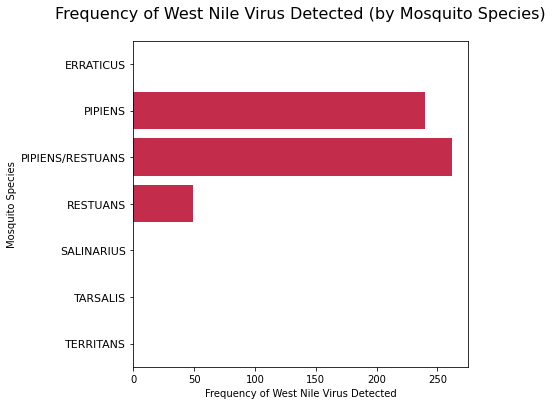

In [6]:
# Plotting a bar chart of frequency of WNV found per mosquito species.
mosquitoes = train_cleaned[["species", "nummosquitos", "wnvpresent"]].groupby(by = "species").sum().reset_index()
plt.figure(figsize = (6,6))
sns.barplot(mosquitoes["wnvpresent"], mosquitoes["species"], color = "crimson")
plt.title("Frequency of West Nile Virus Detected (by Mosquito Species)", fontsize = 16, y = 1.05)
plt.xlabel("Frequency of West Nile Virus Detected")
plt.ylabel("Mosquito Species")
plt.yticks(fontsize = 11)
plt.show()

Based on the chart above, even when Culex Tarsalis is the main mosquito vector of WNV in the USA, we have observed <b>nil WNV detected</b> from Tersalis in our `train_cleaned` dataset. This is also similar for Territans, which is also known to be an important mosquito vector. On the other hand, Restuans had a moderate WNV detection rate despite not being an important mosquito vector. Hence, we conclude that it would be more appropriate to do a <b>One-Hot-Encode</b> of mosquito species instead of giving an inaccurate ordinal ranking to the species based on our `train_cleaned` dataset alone.

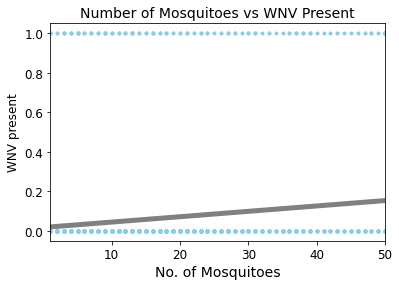

In [21]:
# scatter plot showing relationship between 'number of mosquitoes' and 'WNV present'
sns.regplot(y=train_cleaned['wnvpresent'], x=train_cleaned['nummosquitos'], ci = False, \
                    scatter_kws={'facecolors':'skyblue','edgecolor':'skyblue','s':6},
                    line_kws = {'color':'grey', 'linewidth': 5})
plt.title('Number of Mosquitoes vs WNV Present',fontsize=14)
plt.tick_params(labelsize=12)
plt.xlabel('No. of Mosquitoes', fontsize=14)
plt.ylabel('WNV present', fontsize=12)
plt.grid(False)

### Traps and Satellite Traps
Satellite traps are additional traps set up near established traps to enhance surveillance efforts. The locations of these satellite traps are investigated below.

In [10]:
# find satellite traps
satellite_traps = set([i for i in train_cleaned['trap'] if len(i)>4])
satellite_traps

{'T054C', 'T094B'}

In [11]:
# function to find euclidean distance between traps (in km)
# one unit is equivalent to 1 degree longitude/latitude, which is around 111km
def dist_btwn_traps(trap1, trap2):
    lat1, long1 = train_cleaned[train_cleaned['trap']==trap1].iloc[0][['latitude','longitude']]
    lat2, long2 = train_cleaned[train_cleaned['trap']==trap2].iloc[0][['latitude','longitude']]
    return ((lat1 - lat2)**2 + (long1 - long2)**2) **0.5 *111

# distance between satellite traps and corresponding main traps
print(f"Trap T054: {round(dist_btwn_traps('T054', 'T054C'),5)} km")
print(f"Trap T094: {round(dist_btwn_traps('T094', 'T094B'),5)} km")

Trap T054: 0.44204 km
Trap T094: 0.43479 km


In [13]:
# create dataframe of all possible pairs of traps and distances between them
list_dist = []
traps = set(train_cleaned['trap'].values)

for combi in combinations(traps,2):
    list_dist.append([combi[0],combi[1],dist_btwn_traps(combi[0],combi[1])])
    
df_dist = pd.DataFrame(list_dist, columns=['Trap1', 'Trap2', 'Distance']).sort_values('Distance')

In [14]:
df_dist.reset_index(drop=True, inplace=True)

In [15]:
# 10 furthest pairs of traps
df_dist[::-1][:10]

Trap1 Trap2   Distance
9179  T221  T903  54.730405
9178  T212  T903  53.614591
9177  T903  T215  53.596671
9176  T221  T900  52.468837
9175  T903  T103  52.145424
9174  T903  T100  51.718487
9173  T903  T200  51.599273
9172  T212  T900  51.181256
9171  T900  T215  51.105627
9170  T097  T903  50.218931

In [16]:
# 10 nearest pairs of traps
df_dist[:10]

Trap1 Trap2  Distance
0   T088  T047  0.107148
1   T007  T236  0.183125
2   T089  T085  0.285049
3   T141  T003  0.386987
4   T074  T157  0.408326
5  T094B  T094  0.434787
6  T054C  T054  0.442039
7   T138  T107  0.466087
8   T233  T016  0.506968
9   T209  T206  0.558004

### Dropping of duplicated information on Trap Location
The 2 satellite traps (T094B and T054C) are less than 500 metres away from their main traps (T094 and T054), but there are 5 other pairs of traps that are even closer to each other, with T047 and T088 being around 100 metres apart only.

It is decided not to treat satellite traps as if they are at the location of the main trap.

Since `trap`, `addressnumberandstreet`, `latitude` and `longitude` all tells us the location of the traps placed, we will only be using `latitude` and `longitude` as these two features would give us the coordinates as to where the traps were placed. Hence, we will be dropping the other two features.

In [17]:
# filter all columns related to location
train_cleaned_location = train_cleaned.drop(columns = ['date','species','nummosquitos','wnvpresent'])

# visualising location features
train_cleaned_location.value_counts().sort_index().head(20)

trap  addressnumberandstreet               latitude   longitude 
T001  4000  N TRIPP AVE, Chicago, IL       41.953705  -87.733974     15
T002  4100  N OAK PARK AVE, Chicago, IL    41.954690  -87.800991    185
T003  4600  N MILWAUKEE AVE, Chicago, IL   41.964242  -87.757639    122
T004  4900  W SUNNYSIDE AVE, Chicago, IL   41.962728  -87.748367     12
T005  6000  W ROSCOE ST, Chicago, IL       41.942114  -87.776385     14
T006  6000  N AVONDALE AVE, Chicago, IL    41.990284  -87.797127     24
T007  6200  N MANDELL AVE, Chicago, IL     41.994991  -87.769279     23
T008  7000  N MOSELL AVE, Chicago, IL      42.008314  -87.777921    139
T009  9100  W HIGGINS AVE, Chicago, IL     41.981964  -87.812827     31
      9100  W HIGGINS RD, Chicago, IL      41.992478  -87.862995     80
T011  3600  N PITTSBURGH AVE, Chicago, IL  41.944869  -87.832763    133
T012  6100  N LEMONT AVE, Chicago, IL      41.991429  -87.747113    105
T013  6100  W FULLERTON AVE, Chicago, IL   41.923738  -87.785288    104

In [18]:
# dropping 'trap' and 'addressnumberandstreet' from our train_cleaned dataset
train_cleaned.drop(columns = ['trap','addressnumberandstreet'], inplace = True)

# Weather Feature Engineering and EDA

In [39]:
weather_cleaned.head()

station       date  tmax  tmin  tavg  depart  dewpoint  wetbulb  heat  \
0        1 2007-05-01    83    50  67.0    14.0        51     56.0   0.0   
1        2 2007-05-01    84    52  68.0    14.0        51     57.0   0.0   
2        1 2007-05-02    59    42  51.0    -3.0        42     47.0  14.0   
3        2 2007-05-02    60    43  52.0    -3.0        42     47.0  13.0   
4        1 2007-05-03    66    46  56.0     2.0        40     48.0   9.0   

   cool sunrise sunset  preciptotal  stnpressure  sealevel  resultspeed  \
0   2.0   04:48  18:49          0.0        29.10     29.82          1.7   
1   3.0   04:48  18:49          0.0        29.18     29.82          2.7   
2   0.0   04:47  18:50          0.0        29.38     30.09         13.0   
3   0.0   04:47  18:50          0.0        29.44     30.08         13.3   
4   0.0   04:46  18:51          0.0        29.39     30.12         11.7   

   resultdir  avgspeed  temp_fluct  year mth_day  week   daylight  \
0         27       9.2          33  2007   05-01    18  14.016667   
1         25       9.6          32  2007   05-01    18  14.016667   
2          4      13.4          17  2007   05-02    18  14.050000   
3          2      13.4          17  2007   05-02    18  14.050000   
4          7      11.9          20  2007   05-03    18  14.083333   

   relative_hum  
0      0.564102  
1      0.544973  
2      0.711769  
3      0.685947  
4      0.548489

Research on NCBI suggests that weather is an extremely important factor influencing the mosquito lifecycle, with infection and dissemination rates positively correlating with temperatures (especially above 77 degrees Fahrenheit).

The most important weather factors are:
- Average temperature
- Relative humidity
- Rainfall/precipitation rates
- Temperature fluctuation
- Light intensity


The Koppen weather classification classifies Chicago as a hot summer humid continental.

Most laboratory mosquito research appears to elucidate the relationship between a static temperature and mosquito vector growth rate/ WNV transmission rates. However, in reality, temperature is not perfectly controlled, and instead follows a stochastic pattern. There is insufficient data displaying the effect of a fluctuating or dynamic temperature system on WNV replication and transmission rates.

Instead, research regarding a closely related virus in the flavivirus family, Zika, found that as temperature fluctuations increases, it decreases the ability of mosquitos to transmit the virus. As a result, a variable measuring the fluctuation of temperature would be engineered. As climate change intensifies, the importance of this variable will heighten.

In [22]:
weather_cleaned["temp_fluct"] = weather_cleaned["tmax"] - weather_cleaned["tmin"]

Research on NCBI shows that light intensity is also a critical factor to look at. The steps below show data preparation before engineering of the "daylight" variable as an approximation to light intensity, operationalized by sunset - sunrise. Although this variable shows colinearity with average temperature, laboratory mosquito research has successfully isolated the two, and proven that light intensity alone (independent of temperature increase) would increase important biological steps in the WNV transmission process.

In [23]:
weather_cleaned.dtypes

station          int64
date            object
tmax             int64
tmin             int64
tavg           float64
depart         float64
dewpoint         int64
wetbulb        float64
heat           float64
cool           float64
sunrise         object
sunset          object
preciptotal    float64
stnpressure    float64
sealevel       float64
resultspeed    float64
resultdir        int64
avgspeed       float64
temp_fluct       int64
dtype: object

In [24]:
# create datetime feature - year, month, week, day
weather_cleaned['date'] = pd.to_datetime(weather_cleaned['date'])
weather_cleaned['year'] = weather_cleaned['date'].dt.year
weather_cleaned['mth_day'] = weather_cleaned['date'].dt.strftime("%m-%d")
weather_cleaned['week'] = weather_cleaned['date'].dt.isocalendar().week.astype(int)

In [25]:
#new feature - daylight minutes
weather_cleaned['daylight'] = (weather_cleaned['sunset'].astype('datetime64') - 
                       weather_cleaned['sunrise'].astype('datetime64')).dt.seconds/3600

In [26]:
# function to calculate relative humidity
def cal_rh(temp, dewpoint):
    rh = relative_humidity_from_dewpoint(temperature= temp * units.fahrenheit, 
                                         dewpoint= dewpoint * units.fahrenheit).magnitude
    return rh

# new feature - relative_hum
weather_cleaned['relative_hum'] = weather_cleaned.apply(lambda x: cal_rh(x['tavg'], x['dewpoint']), axis =1)

Text(0, 0.5, 'Total Precipitation (inches)')

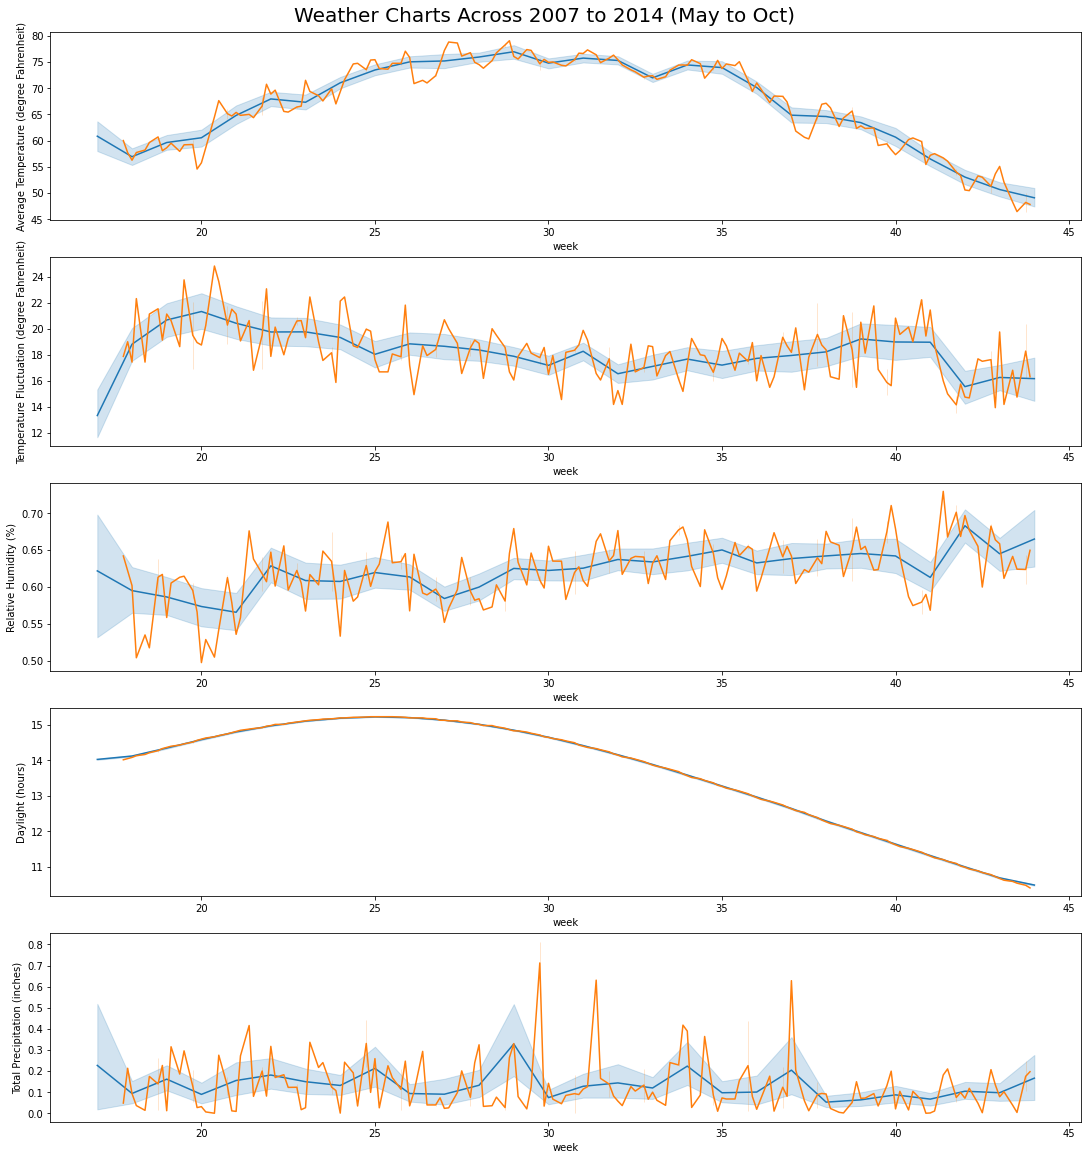

In [27]:
# plot weather charts using average across all years
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(15,16), constrained_layout=True)
fig.suptitle("Weather Charts Across 2007 to 2014 (May to Oct)", fontsize = 20)

sns.lineplot(data=weather_cleaned, x='week', y='tavg', ax=ax[0])
sns.lineplot(data=weather_cleaned.groupby('mth_day').mean(), x='week', y='tavg',ax=ax[0]);

sns.lineplot(data=weather_cleaned, x='week', y='temp_fluct', ax=ax[1])
sns.lineplot(data=weather_cleaned.groupby('mth_day').mean(), x='week', y='temp_fluct',ax=ax[1]);

sns.lineplot(data=weather_cleaned, x='week', y='relative_hum', ax=ax[2])
sns.lineplot(data=weather_cleaned.groupby('mth_day').mean(), x='week', y='relative_hum',ax=ax[2]);

sns.lineplot(data=weather_cleaned, x='week', y='daylight', ax=ax[3]);
sns.lineplot(data=weather_cleaned.groupby('mth_day').mean(), x='week', y='daylight', ax=ax[3]);

sns.lineplot(data=weather_cleaned, x='week', y='preciptotal', ax=ax[4]);
sns.lineplot(data=weather_cleaned.groupby('mth_day').mean(), x='week', y='preciptotal', ax=ax[4]);

ax[0].set_ylabel("Average Temperature (degree Fahrenheit)")
ax[1].set_ylabel("Temperature Fluctuation (degree Fahrenheit)")
ax[2].set_ylabel("Relative Humidity (%)")
ax[3].set_ylabel("Daylight (hours)")
ax[4].set_ylabel("Total Precipitation (inches)")

In [28]:
#create function for plotting
def plot_func(dataframe, attr, **kwarg):
    ''' Plot histogram, scatter plot, box plot, and qq plot in a figure.'''
    row = len(attr)
    col = 3
    figsize = (20, row*4)
    fig, ax = plt.subplots(nrows=row, ncols=col, figsize=figsize, constrained_layout=True) 
    for x in range(row):
            #histogram plot
            sns.histplot(x=attr[x], data=dataframe, ax=ax[x,0], color='tab:red', )
            ax[x, 0].set_title(f'histogram: {attr[x]}')
            ax[x, 0].tick_params(labelrotation=90, axis='x')
            #scatter plot
            sns.scatterplot(x='week', y=attr[x], data=dataframe, ax=ax[x,1])
            ax[x, 1].set_title(f'scatter plot: {attr[x]}')
            ax[x, 1].tick_params(labelrotation=90, axis='x')
            #scatter plot
            sns.scatterplot(x='week', y=attr[x], data=dataframe, ax=ax[x,1])
            ax[x, 1].set_title(f'scatter plot: {attr[x]}')
            ax[x, 1].tick_params(labelrotation=90, axis='x')
            #box plot
            
            #box plot
            sns.boxplot(x=attr[x], data=dataframe, ax=ax[x,2])
            sns.stripplot(x=attr[x], data=dataframe, ax=ax[x,2], alpha= 0.2)
            ax[x, 2].set_title(f'boxplot: {attr[x]}')
            ax[x, 2].tick_params(labelrotation=90, axis='x')
            
    plt.show()

In [29]:
num_features = weather_cleaned.select_dtypes(include='number').columns.to_list()
cat_features = weather_cleaned.select_dtypes(exclude='number').columns.to_list()

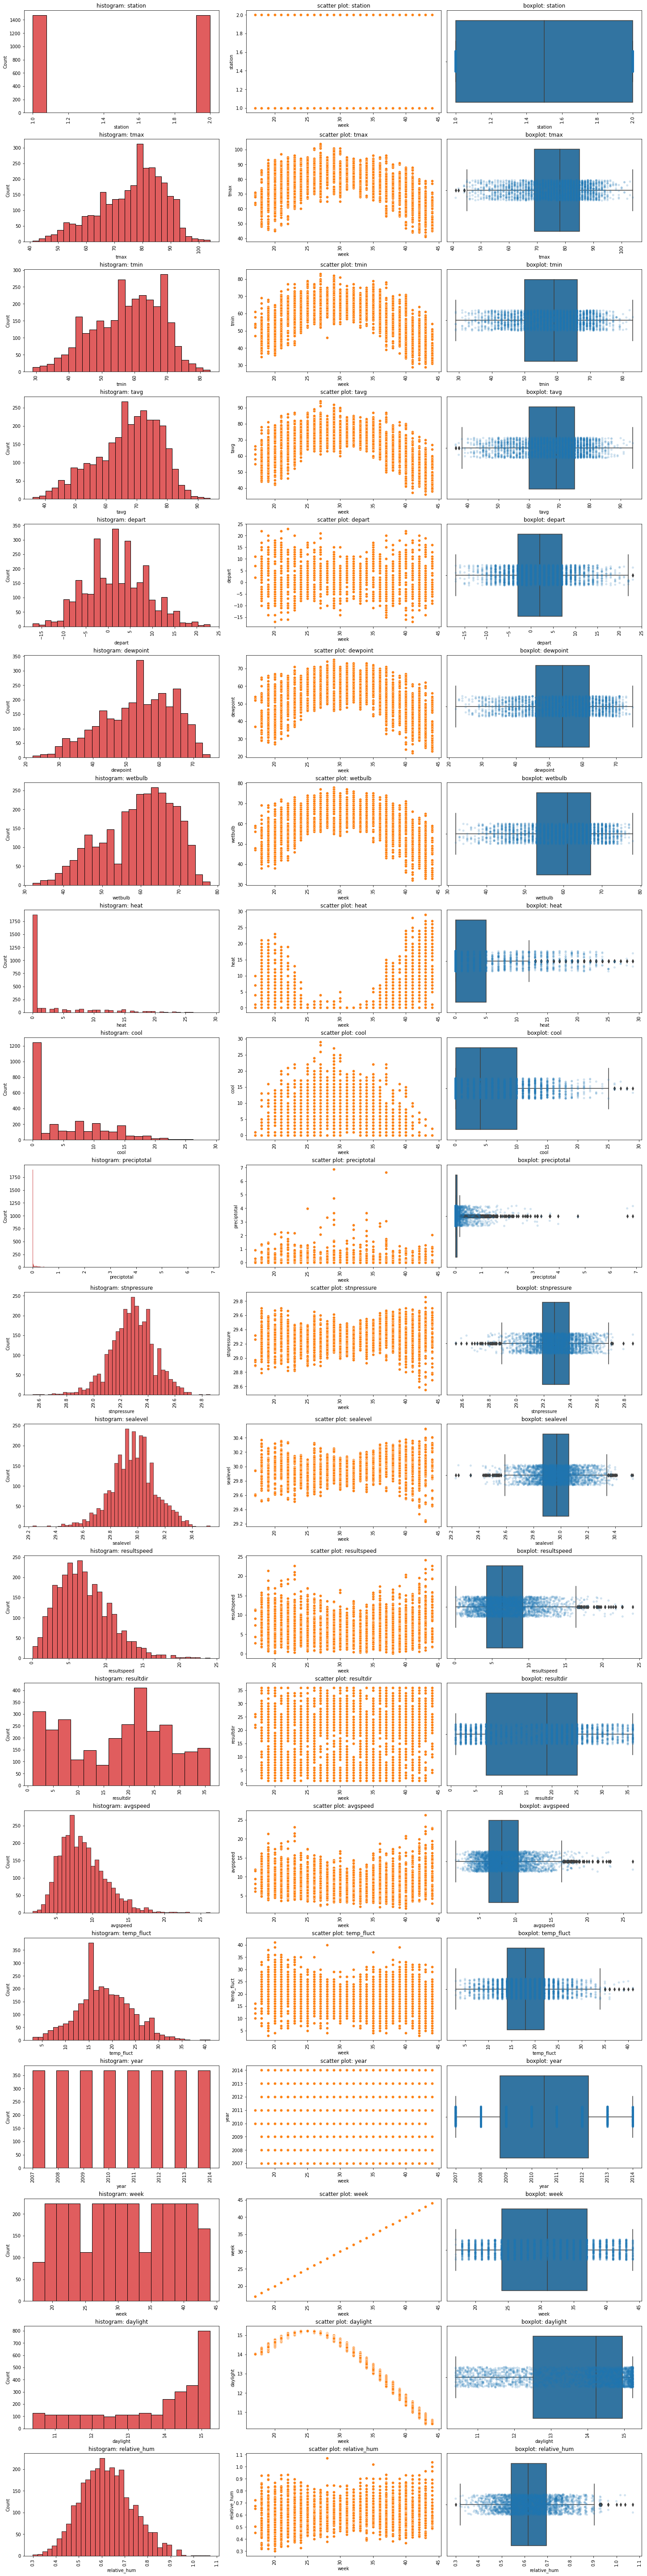

In [30]:
plot_func(weather_cleaned, num_features)

# Merged feature engineering and EDA

In [32]:
weather_cleaned.shape

(2944, 24)

In [33]:
train_cleaned['date'] = pd.to_datetime(train_cleaned['date'])

In [34]:
train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          10506 non-null  datetime64[ns]
 1   species       10506 non-null  object        
 2   latitude      10506 non-null  float64       
 3   longitude     10506 non-null  float64       
 4   nummosquitos  10506 non-null  int64         
 5   wnvpresent    10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 492.6+ KB


In [56]:
merged = train_cleaned.merge(weather_cleaned.groupby('date').mean(), on='date', how='left')
merged.head()

date           species   latitude  longitude  nummosquitos  \
0 2007-05-29  PIPIENS/RESTUANS  41.954690 -87.800991             1   
1 2007-05-29          RESTUANS  41.954690 -87.800991             1   
2 2007-05-29          RESTUANS  41.994991 -87.769279             1   
3 2007-05-29  PIPIENS/RESTUANS  41.974089 -87.824812             1   
4 2007-05-29          RESTUANS  41.974089 -87.824812             4   

   wnvpresent  station  tmax  tmin  tavg  depart  dewpoint  wetbulb  heat  \
0           0      1.5  88.0  62.5  75.5    10.0      58.5     65.5   0.0   
1           0      1.5  88.0  62.5  75.5    10.0      58.5     65.5   0.0   
2           0      1.5  88.0  62.5  75.5    10.0      58.5     65.5   0.0   
3           0      1.5  88.0  62.5  75.5    10.0      58.5     65.5   0.0   
4           0      1.5  88.0  62.5  75.5    10.0      58.5     65.5   0.0   

   cool  preciptotal  stnpressure  sealevel  resultspeed  resultdir  avgspeed  \
0  10.5          0.0       29.415      30.1          5.8       17.0      6.95   
1  10.5          0.0       29.415      30.1          5.8       17.0      6.95   
2  10.5          0.0       29.415      30.1          5.8       17.0      6.95   
3  10.5          0.0       29.415      30.1          5.8       17.0      6.95   
4  10.5          0.0       29.415      30.1          5.8       17.0      6.95   

   temp_fluct    year  week   daylight  relative_hum  
0        25.5  2007.0  22.0  14.933333       0.55584  
1        25.5  2007.0  22.0  14.933333       0.55584  
2        25.5  2007.0  22.0  14.933333       0.55584  
3        25.5  2007.0  22.0  14.933333       0.55584  
4        25.5  2007.0  22.0  14.933333       0.55584

In [43]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          10506 non-null  datetime64[ns]
 1   species       10506 non-null  object        
 2   latitude      10506 non-null  float64       
 3   longitude     10506 non-null  float64       
 4   nummosquitos  10506 non-null  int64         
 5   wnvpresent    10506 non-null  int64         
 6   station       10506 non-null  float64       
 7   tmax          10506 non-null  float64       
 8   tmin          10506 non-null  float64       
 9   tavg          10506 non-null  float64       
 10  depart        10506 non-null  float64       
 11  dewpoint      10506 non-null  float64       
 12  wetbulb       10506 non-null  float64       
 13  heat          10506 non-null  float64       
 14  cool          10506 non-null  float64       
 15  preciptotal   10506 non-null  float6

In [47]:
# plot correlation heatmap
def plot_heatmap(dataframe):
    plt.figure(figsize = (15,15))
    corr = dataframe.corr()

    # Set up mask to be "True" in the upper triangle.
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    
    # Generate heatmap
    sns.heatmap(corr, mask = mask, cmap=sns.color_palette("RdBu_r",7),\
                annot=True, fmt=".2f", cbar_kws = {'shrink': 0.5}, square = True,\
               linewidths = 0.1, vmin=-1, vmax = 1)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.show()

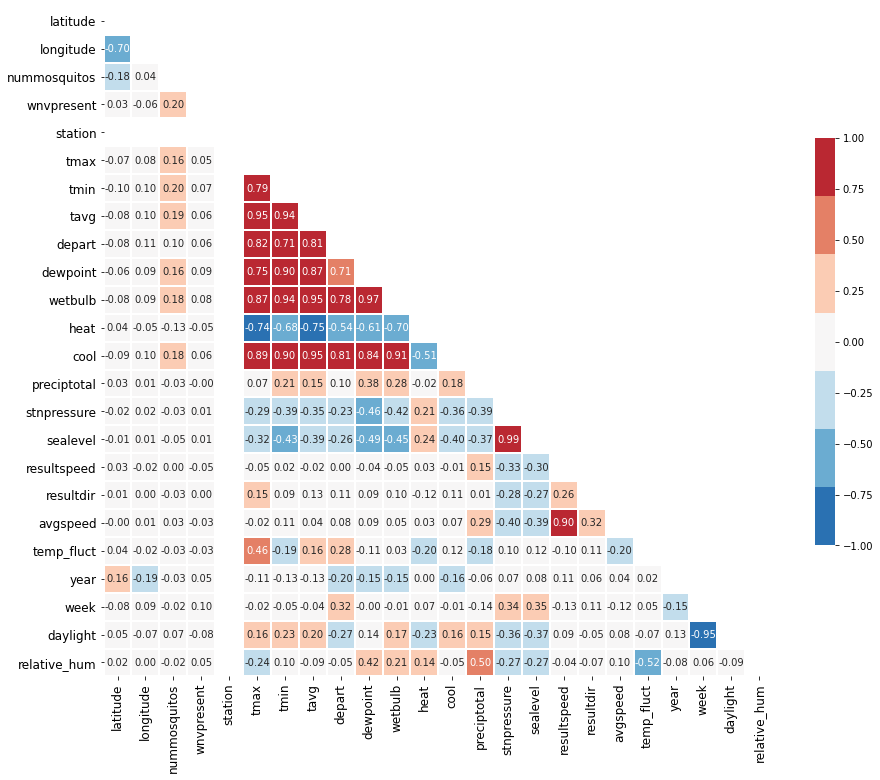

In [48]:
plot_heatmap(merged)

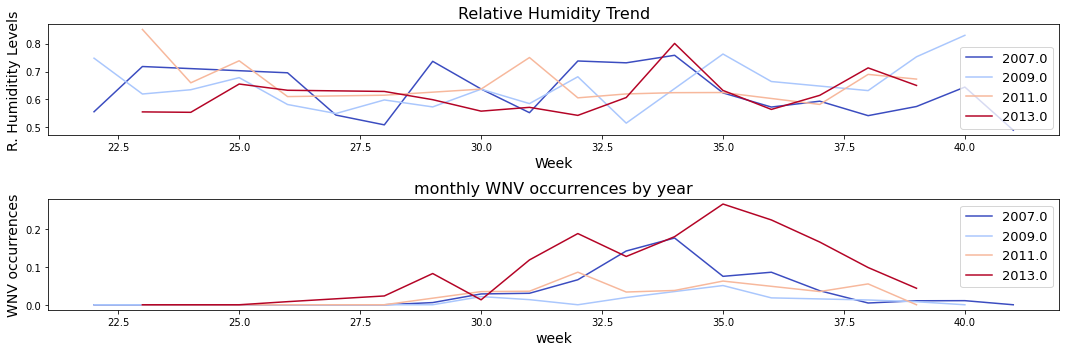

In [54]:
fig, ax = plt.subplots(nrows = 2, figsize=(15,5))

# plot sampling efforts by year
sns.lineplot(data = merged, x='week', y='relative_hum', hue='year', ci = None, 
             palette = 'coolwarm', ax = ax[0])
ax[0].legend(fontsize = 13)
ax[0].set_title('Relative Humidity Trend', fontsize=16)
ax[0].set_xlabel('Week',fontsize=14)
ax[0].set_ylabel('R. Humiditity Levels',fontsize=14)

sns.lineplot(data = merged, x='week', y='wnvpresent', hue='year', ci = None, 
             palette = 'coolwarm', ax = ax[1])
ax[1].legend(fontsize = 13)
ax[1].set_title('monthly WNV occurrences by year', fontsize=16)
ax[1].set_xlabel('week',fontsize=14)
ax[1].set_ylabel('WNV occurrences',fontsize=14)

plt.tight_layout()

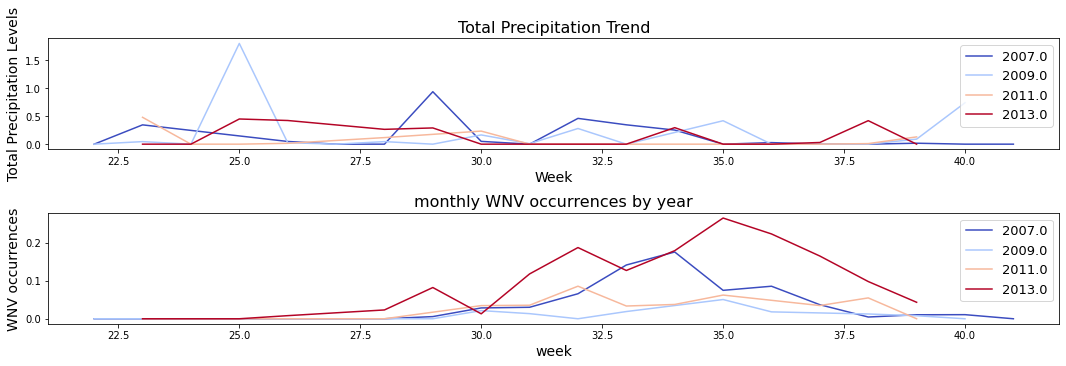

In [57]:
fig, ax = plt.subplots(nrows = 2, figsize=(15,5))

# plot sampling efforts by year
sns.lineplot(data = merged, x='week', y='preciptotal', hue='year', ci = None, 
             palette = 'coolwarm', ax = ax[0])
ax[0].legend(fontsize = 13)
ax[0].set_title('Total Precipitation Trend', fontsize=16)
ax[0].set_xlabel('Week',fontsize=14)
ax[0].set_ylabel('Total Precipitation Levels',fontsize=14)

sns.lineplot(data = merged, x='week', y='wnvpresent', hue='year', ci = None, 
             palette = 'coolwarm', ax = ax[1])
ax[1].legend(fontsize = 13)
ax[1].set_title('monthly WNV occurrences by year', fontsize=16)
ax[1].set_xlabel('week',fontsize=14)
ax[1].set_ylabel('WNV occurrences',fontsize=14)

plt.tight_layout()

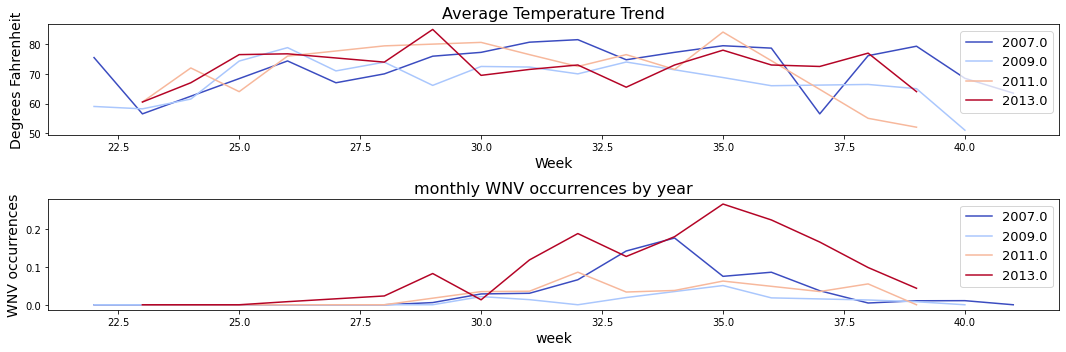

In [58]:
fig, ax = plt.subplots(nrows = 2, figsize=(15,5))

# plot sampling efforts by year
sns.lineplot(data = merged, x='week', y='tavg', hue='year', ci = None, 
             palette = 'coolwarm', ax = ax[0])
ax[0].legend(fontsize = 13)
ax[0].set_title('Average Temperature Trend', fontsize=16)
ax[0].set_xlabel('Week',fontsize=14)
ax[0].set_ylabel('Degrees Fahrenheit',fontsize=14)

sns.lineplot(data = merged, x='week', y='wnvpresent', hue='year', ci = None, 
             palette = 'coolwarm', ax = ax[1])
ax[1].legend(fontsize = 13)
ax[1].set_title('monthly WNV occurrences by year', fontsize=16)
ax[1].set_xlabel('week',fontsize=14)
ax[1].set_ylabel('WNV occurrences',fontsize=14)

plt.tight_layout()

In [ ]:
# # dropping unnecessary columns not related to temperature or humidity
# merged.drop(columns=['station','resultspeed', 'resultdir', 'avgspeed', 'stnpressure', 'sealevel'], inplace=True)
# merged.head()

In [ ]:
# merged.drop(columns=['year', 'week'], inplace=True)
# merged.head()

In [ ]:
# merged.to_csv('../output_data/merged_train.csv', index= False)

# Spray Feature Engineering and EDA

In [60]:
spray_cleaned.head()

date        time   latitude  longitude
0  2011-08-29  6:56:58 PM  42.391623 -88.089163
1  2011-08-29  6:57:08 PM  42.391348 -88.089163
2  2011-08-29  6:57:18 PM  42.391022 -88.089157
3  2011-08-29  6:57:28 PM  42.390637 -88.089158
4  2011-08-29  6:57:38 PM  42.390410 -88.088858

In [63]:
spray_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14294 entries, 0 to 14293
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       14294 non-null  object 
 1   time       13710 non-null  object 
 2   latitude   14294 non-null  float64
 3   longitude  14294 non-null  float64
dtypes: float64(2), object(2)
memory usage: 446.8+ KB


Noted that `time` has some null values. Given that our observations will only be looking at the year, month, day and not scoping into the hours, minutes and seconds of when the sprays were conducted, we propose to drop this column.

In [65]:
# drop 'time'
spray_cleaned.drop(columns = ['time'], inplace = True)

In [68]:
# change to date-time data type
spray_cleaned['date'] = pd.to_datetime(spray_cleaned['date'])

# create new df based on year
spray_2011 = spray_cleaned[spray_cleaned['date'].dt.year == 2011]
spray_2013 = spray_cleaned[spray_cleaned['date'].dt.year == 2013]

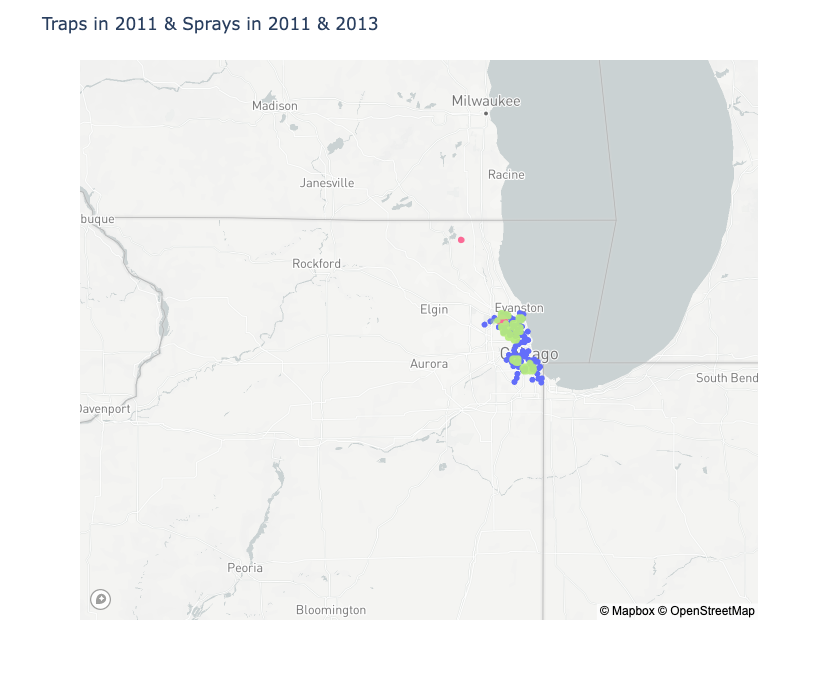

In [76]:
px.set_mapbox_access_token(MAPBOX_TOKEN)
fig = px.scatter_mapbox(merged[merged['year'] == 2011], lat = 'latitude', lon  = 'longitude',
                        size_max=20, zoom = 10)
fig2 = px.scatter_mapbox(spray_2011, lat = 'latitude', lon  = 'longitude',
                        size_max=15, zoom = 10, color_discrete_sequence = ['#FF6692'],
                        opacity = 0.1, hover_data = ['date'])
fig3 = px.scatter_mapbox(spray_2013, lat = 'latitude', lon  = 'longitude',
                        size_max=15, zoom = 10, color_discrete_sequence = ['#B6E880'],
                        opacity = 0.1, hover_data = ['date'])

fig.add_trace(fig2.data[0]) # adds fig2 to the first figure
fig.add_trace(fig3.data[0]) # adds fig3 to the first figure

fig.update_layout(title = 'Traps in 2011 & Sprays in 2011 & 2013',
    autosize=False,
    width=900,
    height=700)


fig.show()

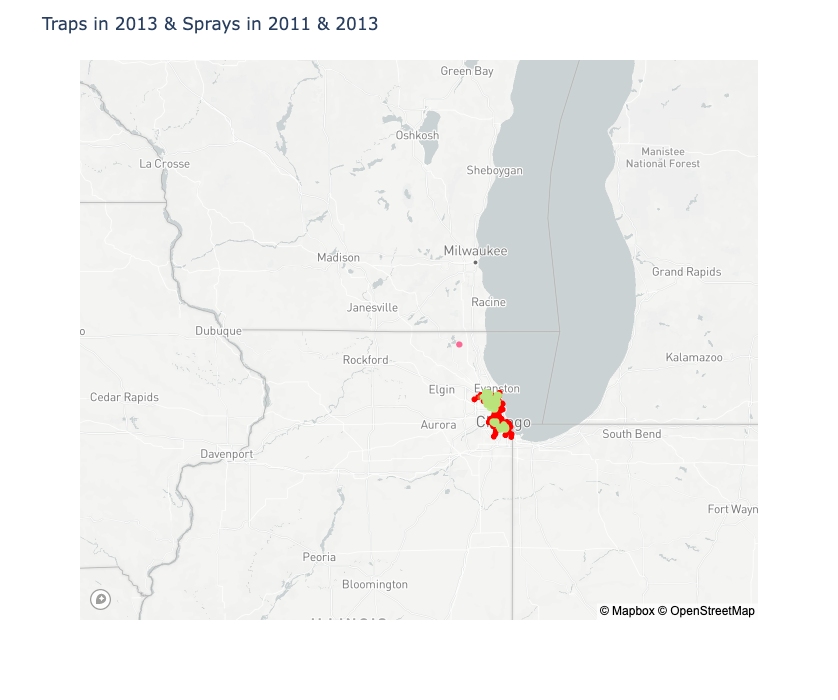

In [79]:
fig = px.scatter_mapbox(merged[merged['year'] == 2013], lat = 'latitude', lon  = 'longitude',
                        size_max=20, zoom = 10, color_discrete_sequence = ['red'])
fig2 = px.scatter_mapbox(spray_2011, lat = 'latitude', lon  = 'longitude',
                        size_max=15, zoom = 10, color_discrete_sequence = ['#FF6692'],
                        opacity = 0.1, hover_data = ['date'])
fig3 = px.scatter_mapbox(spray_2013, lat = 'latitude', lon  = 'longitude',
                        size_max=15, zoom = 10, color_discrete_sequence = ['#B6E880'],
                        opacity = 0.1, hover_data = ['date'])

fig.add_trace(fig2.data[0]) # adds fig2 to the first figure
fig.add_trace(fig3.data[0]) # adds fig3 to the first figure

fig.update_layout(title = 'Traps in 2013 & Sprays in 2011 & 2013',
    autosize=False,
    width=900,
    height=700)


fig.show()